iset-cli-port0 CI Value for max packet 614434629859: 99.266778069562750571458442649941389390733093023300170898437500
iset-cli-port0 Correspondence rx_fcs_error_value = 0
iset-cli-port0 CI Value for max packet 1358159520893: 99.99808895674867293233017712800192455802061886060982942581176757812500
iset-cli-port0 Correspondence rx_fcs_error_value = 0
iset-cli-port0 CI Value for max packet 1311900105270: 99.9972331081266982453299631966592286858031002338975667953491210937500
iset-cli-port0 Correspondence rx_fcs_error_value = 0
iset-cli-port0 CI Value for max packet 1377558799070: 99.9983636714022045169456432561760905741721217054873704910278320312500
iset-cli-port0 Correspondence rx_fcs_error_value = 0
iset-cli-port0 CI Value for max packet 1360529996446: 99.99812485593075313777919766594637351886376563925296068191528320312500
iset-cli-port0 Correspondence rx_fcs_error_value = 0
iset-cli-port0 CI Value for max packet 1303152133404: 99.99703253397697854442456762147362070436429348774254322052001

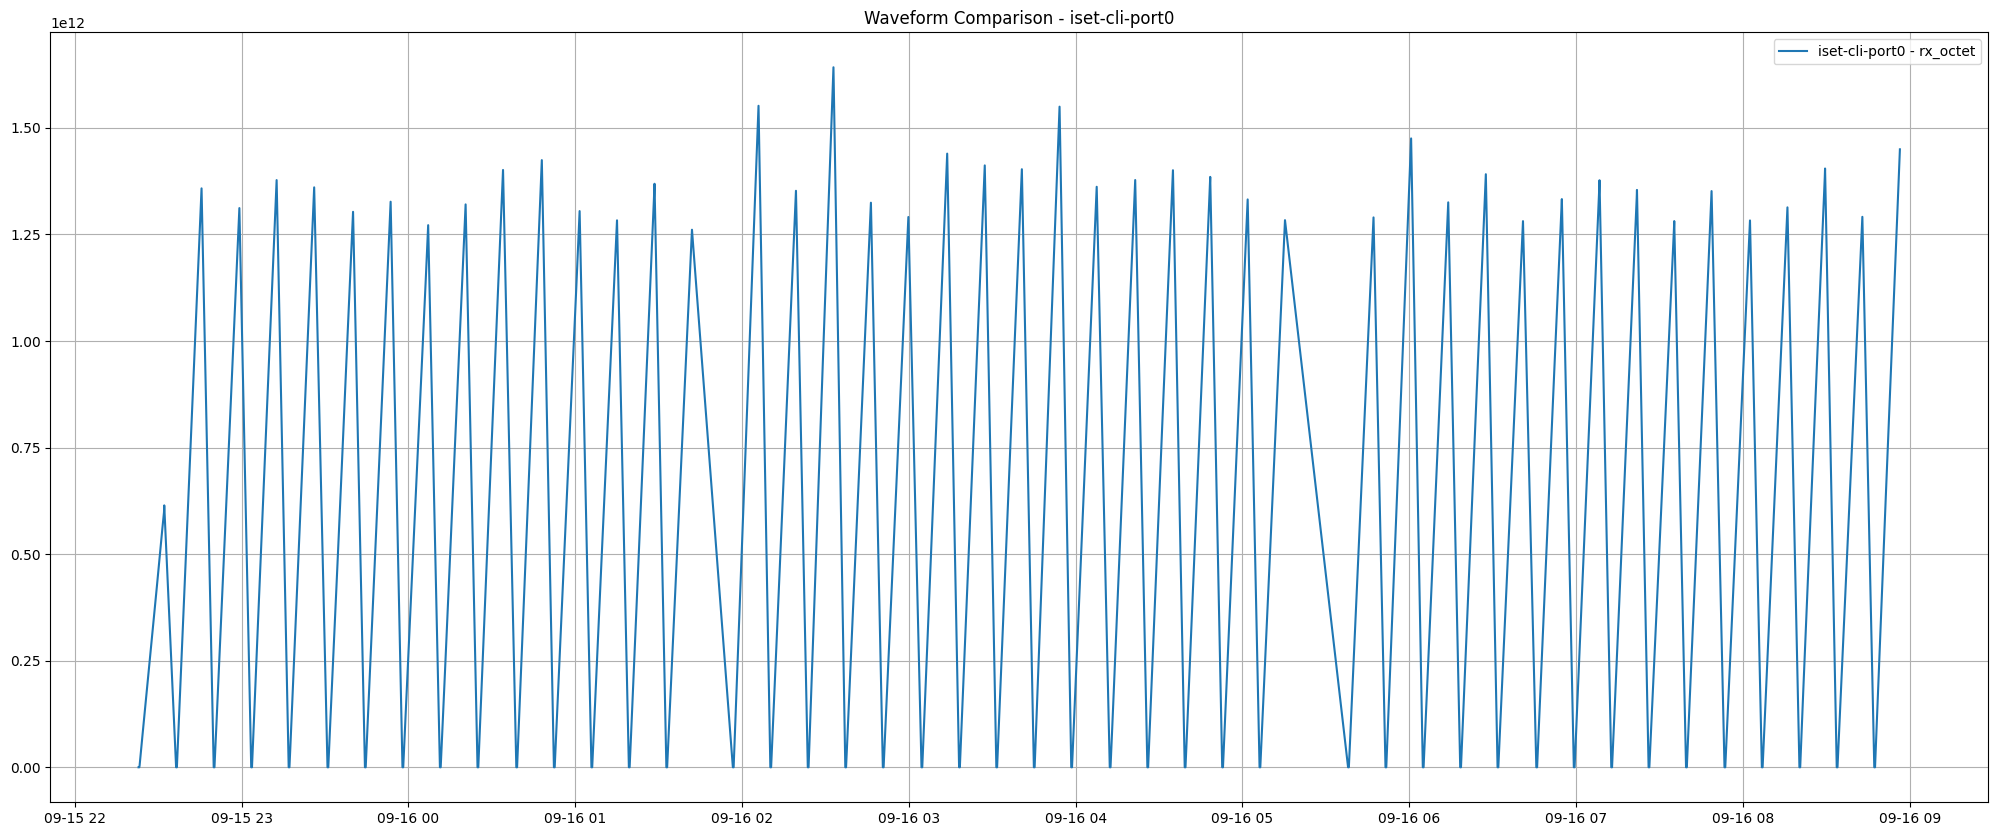

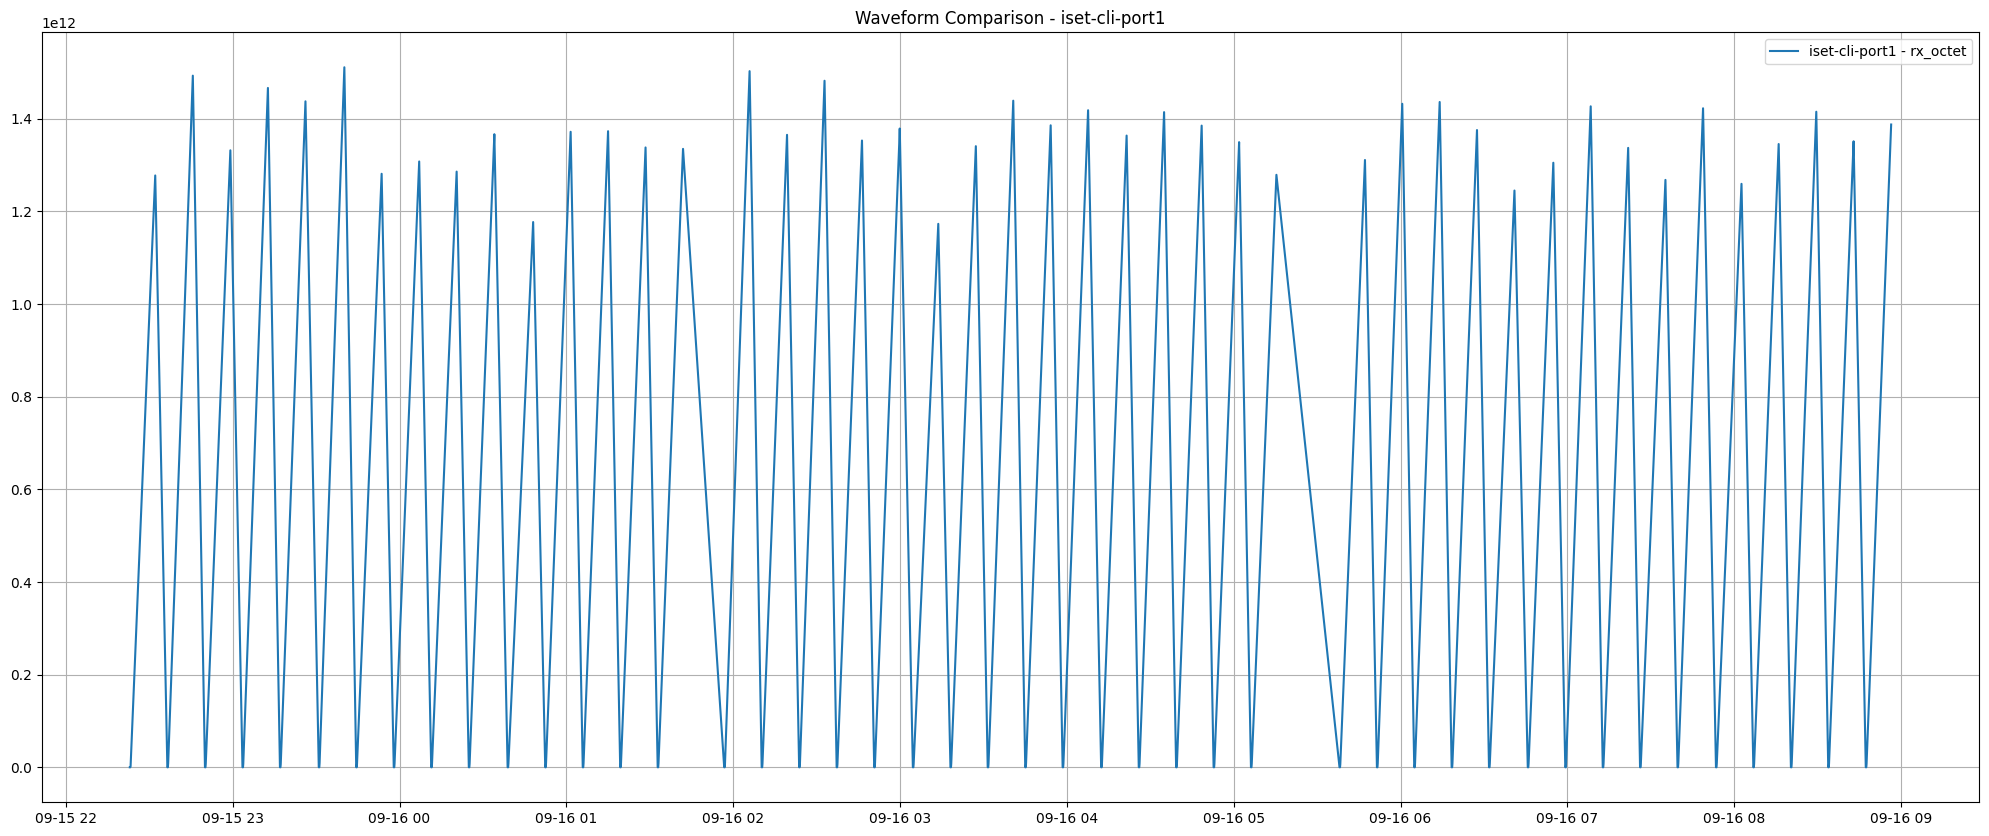

In [3]:

from openpyxl.styles import PatternFill
import math
from decimal import Decimal, getcontext
from pathlib import Path
from nptdms import TdmsFile
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows

getcontext().prec = 1000


# Define the CI function
def CI(n):
    r = Decimal('1e-12')
    if n * r < Decimal('-900'):  # A threshold value for extreme cases
        return Decimal('100.0')  # Return 100% as an approximation
    else:
        return Decimal('100') * (1 - Decimal(math.exp(-n*8 * r)))



def CI2(rx_packet):

    packet_size = 1496
    ber_spec = 1e-12
    ber_factor = 1 - ber_spec
    return 100*(1 - 10**((rx_packet / ((1/8) * (1 / packet_size)))*math.log10(ber_factor)))


    # Define custom fill patterns for "Passed" and "Failed" results
pass_fill = PatternFill(start_color="00FF00", end_color="00FF00", fill_type="solid")  # Green
fail_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")  # Red

# Load ATS data
tdms_file_path_Ats = Path(r"\\lno\9284\ATS.tdms")
tdms_file_Ats = TdmsFile(tdms_file_path_Ats)
group_of_interest = ["Info"]
channel_of_interest_time = 'Time'
channel_of_interest_info = 'Info'
data_df = pd.DataFrame()

for group_name in group_of_interest:
    group_Ats = tdms_file_Ats[group_name]
    data_df['Time'] = pd.DataFrame(group_Ats[channel_of_interest_time])
    data_df['Info'] = pd.DataFrame(group_Ats[channel_of_interest_info])

# Define the list of groups you want to process
groups_of_interest = ["iset-cli-port0", "iset-cli-port1"]
channel_of_interest_rx_octet = "rx_octet"
channel_of_interest_rx_fcs_error = "rx_fcs_error"
time_channel = "Time"


# Initialize a list to store closest times for each "stop" event
closest_times = []

# Create a workbook to store the results
workbook = openpyxl.Workbook()
excel_filename = "CI_Ber_RunID_9287.xlsx"
# Define custom fill patterns for "Passed" and "Failed" results
# pass_fill = PatternFill(start_color="00FF00", end_color="00FF00", fill_type="solid")  # Green
# fail_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")  # Red

for group_name in groups_of_interest:
    # Load RX data for the current group
    tdms_file = TdmsFile.read(r"\\lno\9284\acc-traffic.tdms")

    # Filter RX data for the current group
    group = tdms_file[group_name]
    rx_df = pd.DataFrame()
    rx_df['rx_octet'] = pd.DataFrame(group[channel_of_interest_rx_octet])
    rx_df['RX_Time'] = pd.DataFrame(group[time_channel].data)
    rx_df['rx_fcs_error'] = pd.DataFrame(group[channel_of_interest_rx_fcs_error])

    # Find "stop" events in data_df for the current group
    stop_events = data_df[data_df['Info'].str.contains('Stop')]

    # Initialize a list to store closest times for the current group
    group_closest_times = []

    # Loop through each "stop" event and find the closest time in the current group's rx_df
    for stop_time in stop_events['Time']:
        closest_time = rx_df.loc[rx_df['RX_Time'] < stop_time, 'RX_Time'].max()
        group_closest_times.append(closest_time)

    # Create a new DataFrame to store the closest times for the current group
    closest_times_df = pd.DataFrame({'Stop_Time': stop_events['Time'], f'Closest_RX_Time_{group_name}': group_closest_times})

    # Merge the closest_times_df with the current group's rx_df
    merged_df = rx_df.merge(closest_times_df, left_on='RX_Time', right_on=f'Closest_RX_Time_{group_name}', how='inner')

    # Drop the 'Closest_RX_Time' column if you no longer need it
    merged_df = merged_df.drop(f'Closest_RX_Time_{group_name}', axis=1)

    # Store the closest times for the current group in the overall closest_times list
    closest_times.append(group_closest_times)

    # Access the calculated values for the current group
    rx_octet_values = merged_df['rx_octet'].values
    rx_fcs_error_values = merged_df['rx_fcs_error'].values

    # Create a new worksheet for the data and results
    worksheet = workbook.create_sheet(title=group_name)



    # Add the results for Port0 and Port1 to the worksheet
    results = []

    for n, m in zip(rx_octet_values, rx_fcs_error_values):
        n = Decimal(float(n))
        CI_value = CI(n)
        print(f"{group_name} CI Value for max packet {n}: {CI_value}")
        print(f"{group_name} Correspondence rx_fcs_error_value = {m}")

        if CI_value is not None:
            if CI_value >= 99.99:
                result_value = "Passed"
                result_fill = pass_fill
            else:
                result_value = "Failed"
                result_fill = fail_fill

        else:
            result_value = 'N/A'  # Handle the case when CI2(n) returns None
            result_fill = None

        formatted_n = format(n, '.0f')  # Format n to display as a whole number
        formatted_m = format(m, '.0f')  # Format m to display as a whole number

        results.append([formatted_n, formatted_m, CI_value, result_value])

    # Append results to the worksheet and apply the cell fill
    for row in results:
        worksheet.append(row)

    # Apply the cell fill for the "Passed" and "Failed" results
    for row in worksheet.iter_rows(min_row=2, max_row=worksheet.max_row, min_col=4, max_col=4):
        for cell in row:
            cell.fill = result_fill
    # Plot the 'rx_octet' data to the right
    plt.figure(figsize=(25, 10))
    plt.plot(rx_df['RX_Time'], rx_df['rx_octet'], label=f'{group_name} - rx_octet')
    plt.axis('on')  # Turn off axis labels and ticks
    plt.title(f"Waveform Comparison - {group_name}")
    plt.grid(True)
    plt.legend()

    # Save the plot as an image
    plot_filename = f"{group_name}_plot.png"
    plt.savefig(plot_filename)

        # Create an Image instance and anchor it to a cell to the right of the result table
    img = Image(plot_filename)
    img.width = img.width * 0.7  # Adjust image size if needed
    img.height = img.height * 0.7  # Adjust image size if needed
    worksheet.add_image(img, 'E5')  # Adjust the cell reference as needed

# Remove the default sheet created with the workbook
workbook.remove(workbook.active)

# Save the Excel file
workbook.save(excel_filename)



array([1277578002881, 1493031837137, 1331854724718, 1466495879162,
       1437614565182, 1511134117542, 1281218116601, 1307798442480,
       1285905268214, 1366645997933, 1177024739066, 1371855536818,
       1373145271064, 1338046013011, 1334996107066, 1502774997636,
       1365304032926, 1482051429453, 1353008894756, 1378857731315,
       1173138242822, 1340787751913, 1439002331206, 1385847801093,
       1418377877734, 1363677162394, 1414300353807, 1385199037218,
       1349511152304, 1278995120156, 1310953601856, 1432332249551,
       1436190754396, 1375625906445, 1245055406948, 1305051286081,
       1426822499248, 1337122288538, 1268026292451, 1422612440334,
       1259508601674, 1345431600890, 1415162852379, 1351337473848,
       1387566607685], dtype=uint64)